In [41]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

In [42]:
# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [43]:
# Spring-mass-damper parameters
m = 1.0  # Mass (kg)
c = 0.5  # Damping coefficient (Ns/m)
k = 2.0  # Spring constant (N/m)
a = 0 # Constant force of 0 N

# Control Parameters
k_x = 0 # currently no control
k_xdot = 0

F0 = m*a

# Noise for measurements: (standard deviations)
v = [0.05, 0.05] # Position, velocity noise

# Desired trajectory

In [44]:
def desired_trajectory(t):
    x_desired = 0*np.ones_like(t)
    return x_desired

# Nonlinear continuous time dynamics with control

In [45]:
def control(X, t):
    x, xdot = np.ravel(X)
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [46]:
def f(X, t):
    x, xdot = X
    
    # control
    F = control(X, t)
    
    # dynamics
    d_x = xdot
    d_xdot = (-k*x)/m -c*xdot/m + F0/m
    
    d_x = [d_x, d_xdot]
    
    return d_x

# Run simulation

In [47]:
t = np.arange(0, 10, 0.01) # Time

x0 = np.array([1.0, 0.0])  # Initial displacement and velocity

result = odeint(f, x0, t)
X = result.T

# Plot results

Plot the simulation results. These are the true states of the system. 

In [48]:
x = X[0, :]
xdot = X[1, :]

x_des = desired_trajectory(t)

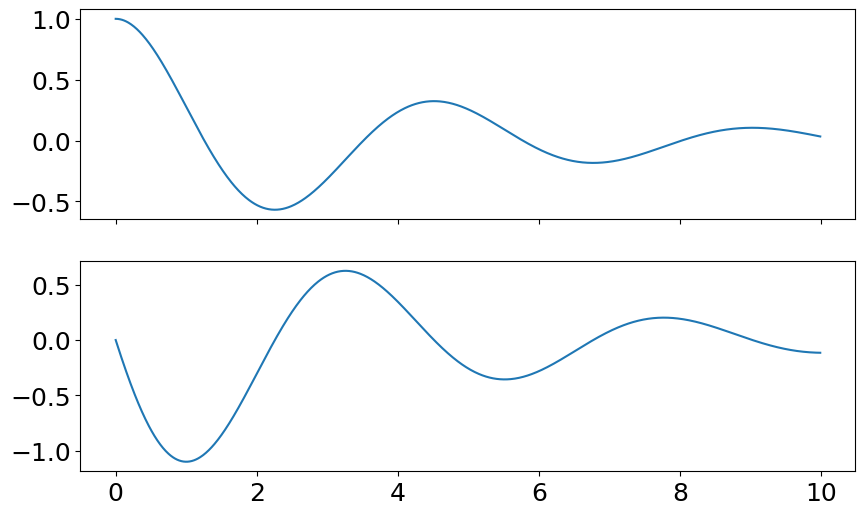

In [49]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
# ax[0].plot(t, x_des, label='x_des', linestyle='--')
ax[1].plot(t, xdot, label='xdot')

# Measurements

Now, we will generate noisy measurements. 

In [50]:
def h(x, v):
    x, xdot = x
    
    y = np.array([x, xdot])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )
    
    return (y + noise).tolist()

In [51]:
Y = np.vstack( [h(X[:,i], v) for i in range(X.shape[1]) ] ).T
print(np.shape(Y))

(2, 1000)


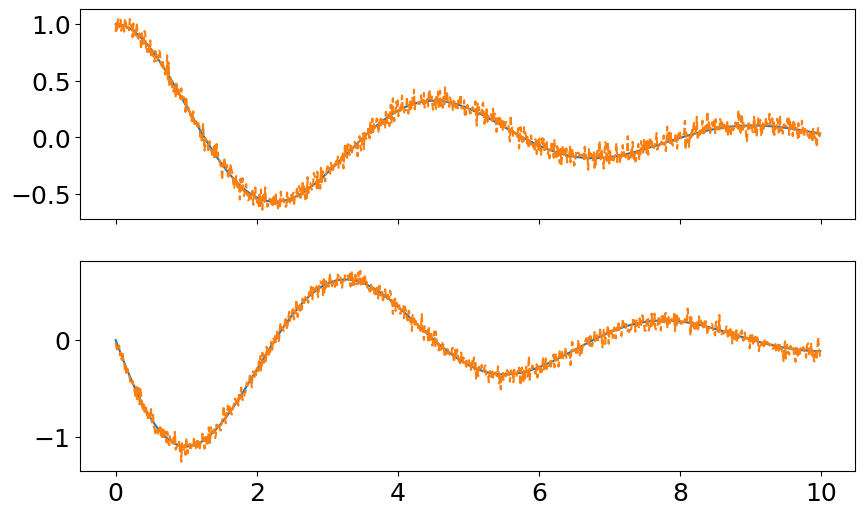

In [12]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x')
ax[0].plot(t, Y[0, :], label='x_m', linestyle='--')
ax[1].plot(t, xdot, label='xdot')
ax[1].plot(t, Y[1, :], label='xdot_m', linestyle='--')

# Discrete Linearized

In [13]:
def control_linear(X, t):
    x, xdot = X
    
    # desired trajectory
    x_desired = desired_trajectory(t)
    
    # error
    x_err = x_desired - x
    
    # control
    F = (k_x*x_err)
    
    return F

In [27]:
# Here, we will define the dyanmics of the system
import itertools
dt = np.mean(np.diff(t))

A = np.array([[0, 1],
              [-k/m, -c/m]])

B = np.array([[0],
              [1/m]])

C_original = np.array([[1, 0],
                       [0, 1]])
# Get all the unique combinations of rows in C
C = []
num_rows = len(C_original)
for r in range(1, num_rows + 1):  # r determines subset size
    for combo in itertools.combinations(C_original, r):
        print(np.array(combo))  # Each combo is a tuple of rows
        print()
        C.append(combo)

# will also need to get unique D matrices based on the size of C
D = []
for i in range(len(C)):
    length = len(C[i])
    unique_D = np.zeros([length, 2])
    D.append(unique_D)

[[1 0]]

[[0 1]]

[[1 0]
 [0 1]]



# Organize some inputs for the KF

In [52]:
def get_params(Cmat):
    # get the control inputs -- these should be known
    u = control_linear(X, t)
    u = np.vstack(u).T

    # R is determined by the variance, thus the square of the standard deviation
    v = [0.05] * len(Cmat)
    R = np.diag(v)**2 # make sure R matches the dimensions of C!!!!! and Y

    # Q defines how trustworthy the model is. More trusted models result in smoother estimates. 
    # But they can be led astray, and are slower to converge 
    Q = 0.025*np.eye(len(Cmat))

    # initial state estimate
    x0 = np.array([10, 5])  # Initial displacement and velocity
    x0 = np.atleast_2d(x0).T

    # initial covariance estimate
    P0 = 0.1*np.eye(len(Cmat)) # Make sure this changes with the dimensions of C and Y!!!
    return x0, P0, u, R, Q

# Run the KF

In [53]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [54]:
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/discrete_linear_kalman.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('discrete_linear_kalman.py', 'w') as f:
    f.write(r.text)
f.close()

from discrete_linear_kalman import __kalman_forward_filter__

In [56]:
for i in range(len(C)):
    x0, P0, u, R, Q = get_params(C[i])
    xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C[i], R, Q)
    
    # Ensure the results are numpy arrays
    xhat_fp = np.array(xhat_fp)
    xhat_fm = np.array(xhat_fm)
    P_fp = np.array(P_fp)
    P_fm = np.array(P_fm)

# xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C, R, Q)

AttributeError: 'tuple' object has no attribute 'T'

In [313]:
x_hat = xhat_fp[0, :]
xdot_hat = xhat_fp[1, :]

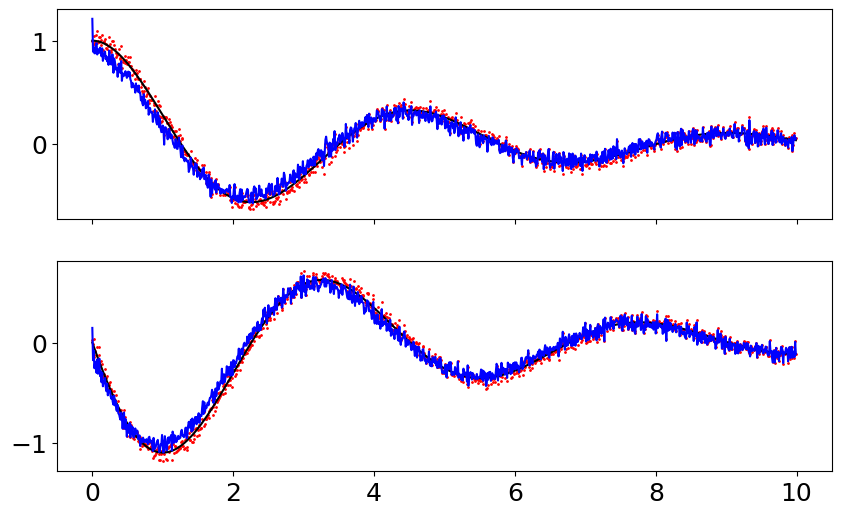

In [314]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True) 
# plot x and xdot
ax[0].plot(t, x, label='x', color='black')
ax[0].scatter(t, Y[0, :], label='x_m', color='red', s=1)
ax[0].plot(t, x_hat, label='x_hat', color='blue')
ax[1].plot(t, xdot, label='xdot', color='black')
ax[1].scatter(t, Y[1, :], label='xdot_m', color='red', s=1)
ax[1].plot(t, xdot_hat, label='xdot_hat', color='blue')

# Analyze the error

DO everything for both position (x) and velocity (xdot)

In [315]:
# Covariance for state x
Px = np.dstack(P_fp)[0,0,:]
# Covariance for state xdot
Pxdot = np.dstack(P_fp)[1,1,:]

Recall that P is the covariance, so its diagonals are the variance. Variance = (Standard Deviation)^2.


In theory, the errors in the estimates should be well approximated by a Normal distribution with zero mean and standard deviation determined by the diagonal element of P. Lets see.

Text(0, 0.5, 'frequency')

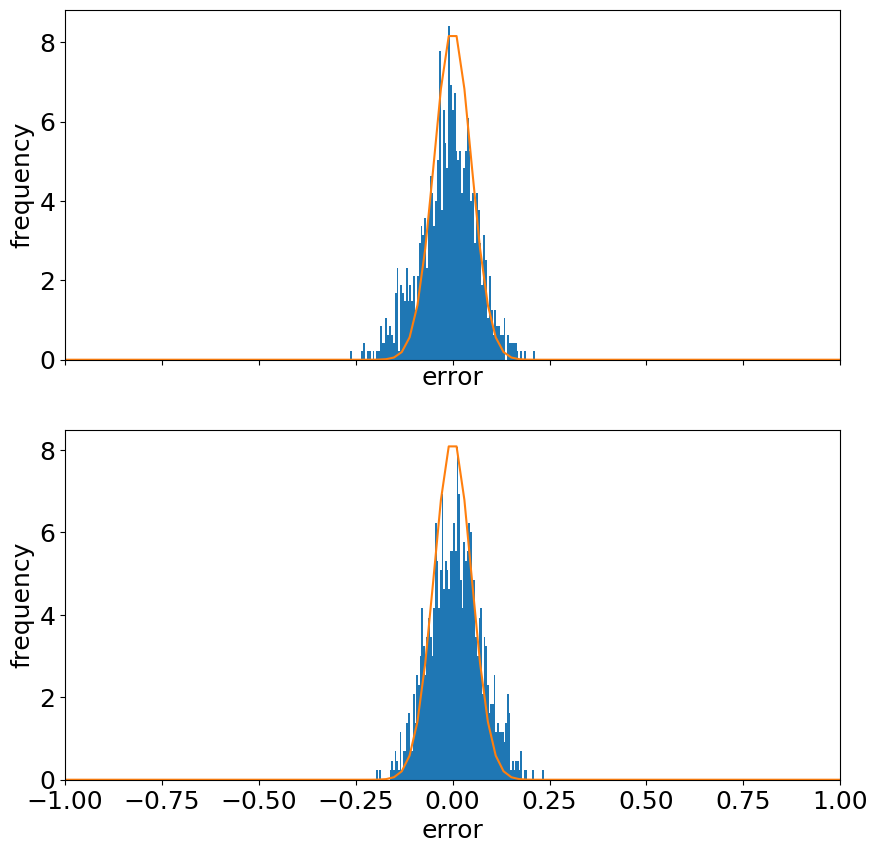

In [316]:
import scipy.stats

xr = np.linspace(-1, 1, 100)
N_x = scipy.stats.norm(0, np.mean(Px)**0.5 )
pdf_x = N_x.pdf(xr)

N_xdot = scipy.stats.norm(0, np.mean(Pxdot)**0.5)
pdf_xdot = N_xdot.pdf(xr)


fig, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)
ax[0].hist(x_hat-x, bins=100, density=True)
ax[0].plot(xr, pdf_x)

ax[0].set_xlim(-1,1)

ax[0].set_xlabel('error')
ax[0].set_ylabel('frequency')


ax[1].hist(xdot_hat-xdot, bins=100, density=True)
ax[1].plot(xr, pdf_xdot)

ax[1].set_xlim(-1,1)

ax[1].set_xlabel('error')
ax[1].set_ylabel('frequency')

Furthermore, 97.7% of the errors should lie under the 3*$\sigma$ bounds. Let's see. 

Text(0, 0.5, 'Error')

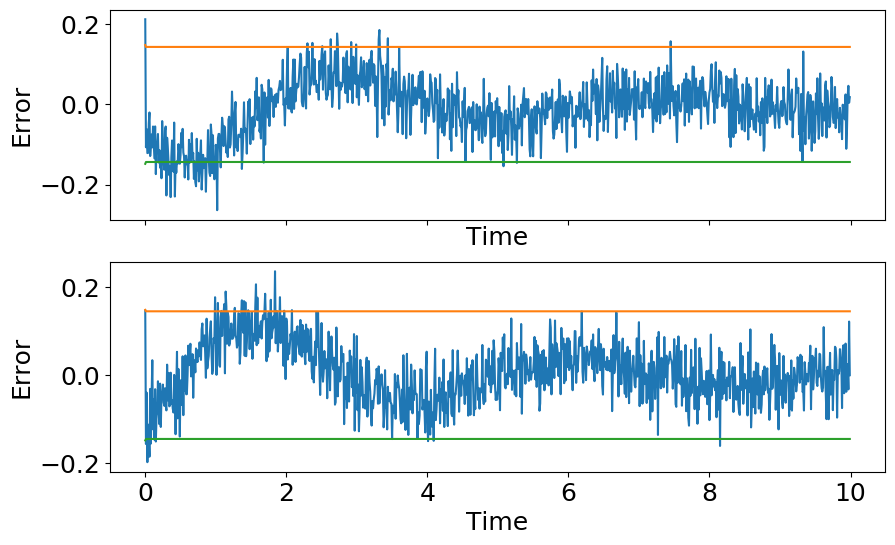

In [317]:
sigma_x = Px**0.5
sigma_xdot = Pxdot**0.5

fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(t, x_hat-x)
ax[0].plot(t, 3*sigma_x)
ax[0].plot(t, -3*sigma_x)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Error')

ax[1].plot(t, xdot_hat-xdot)
ax[1].plot(t, 3*sigma_xdot)
ax[1].plot(t, -3*sigma_xdot)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Error')

# Plotting with Error

Now, I will plot my state estimates with a 3 sigma region

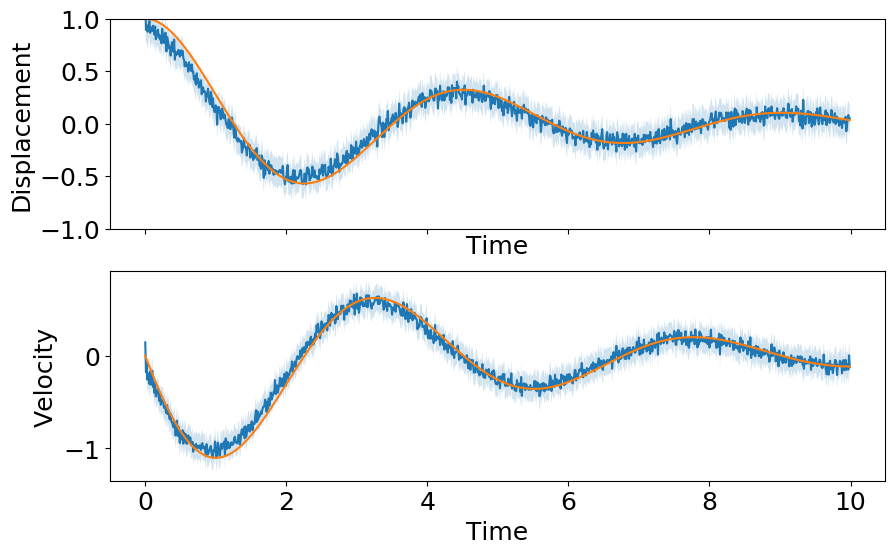

In [318]:
# Plot the state estimates of x and xdot with their 3 sigma bounds
fig, ax = plt.subplots(2, 1, figsize=(10, 6), sharex=True)
ax[0].plot(t, x_hat, label='x_hat')
ax[0].plot(t, x, label='x')
ax[0].fill_between(t, x_hat-3*sigma_x, x_hat+3*sigma_x, alpha=0.2)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Displacement')
ax[0].set_ylim(-1, 1)

ax[1].plot(t, xdot_hat, label='xdot_hat')
ax[1].plot(t, xdot, label='xdot')
ax[1].fill_between(t, xdot_hat-3*sigma_xdot, xdot_hat+3*sigma_xdot, alpha=0.2)
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Velocity')

plt.show()

# Sorting Out Based on Large Error

Now, I will try and disregard a sensor if the error in the sensor is large. 

In [ ]:
# Say weather or not a state estimate is valid based on the average covariance
valid = 0.01
if np.median(Px) < valid:
    print('x is valid')
else:
    print('x is not valid')

if np.median(Pxdot) < valid:
    print('xdot is valid')
else:
    print('xdot is not valid')

x is valid
xdot is valid
[0.00243902 0.00229097 0.00229026 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024 0.00229024
 0.00229024 0.00229024 0.00229024 0.0